In [1]:
import torch
from torch import nn
from functools import partial
import einops
import matplotlib.pyplot as plt

from typing import Tuple

In [2]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def embed(self, p, dim):
        half_dim = dim // 2
        embeddings = torch.log(torch.tensor(self.dim//16)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=p.device) * -embeddings)
        embeddings = p[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

    def forward(self, p_x, p_y):
        half_dim = self.dim // 2
        embeddings_x = self.embed(p_x, half_dim)
        embeddings_y = self.embed(p_y, half_dim)
        embeddings = torch.cat((embeddings_x, embeddings_y), dim=-1)
        return embeddings

pos_embedding: torch.Size([1024, 128])


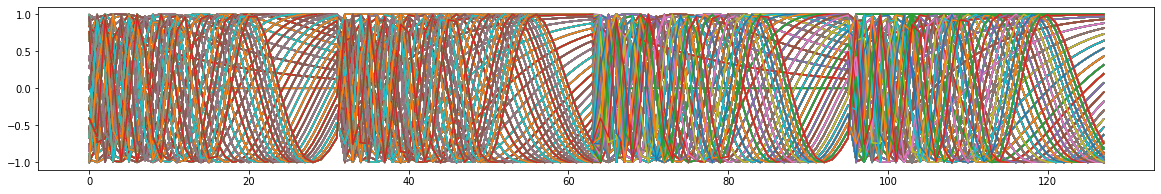

In [3]:



img_size = 1024
patch_size = 32
patches_in_row = img_size//patch_size
n_patches = (patches_in_row) ** 2

p_x = torch.arange(patches_in_row)
p_y = torch.arange(patches_in_row)
poses = torch.cartesian_prod(p_x, p_y)

sembed = SinusoidalPositionEmbeddings(dim=128)
pos_embedding = sembed(poses[:,0], poses[:,1])
print(f"pos_embedding: {pos_embedding.shape}")

labels = []
for i, j in poses:
    labels.append(f"({i}, {j})")

plt.figure(figsize=(20, 3))
plt.plot(pos_embedding.T, label=labels)
# plt.legend()

None

In [60]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
        patch_size: Tuple[int, int],
        latent_size: int,
        hw_size: Tuple[int, int],
        n_channel: int,
        *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        
        self.patch_size = patch_size
        
        self.linear_projection = nn.Linear(patch_size[0]*patch_size[1]*n_channel, latent_size)
        self.segment_token = nn.Parameter(torch.randn(1, latent_size), requires_grad=True)
        
        p_r = torch.arange(1, hw_size[0]//patch_size[0]+1)
        p_c = torch.arange(1, hw_size[1]//patch_size[1]+1)
        poses = torch.cartesian_prod(p_r, p_c)+1
        poses = torch.concat([torch.zeros((1, 2)), poses], dim=0)
        sembed = SinusoidalPositionEmbeddings(dim=latent_size)
        self.pos_embedding = sembed(poses[:,0], poses[:,1])
        
    def forward(self, x):
        patches = einops.rearrange(
            x, 
            "b c (h h1) (w w1) -> b (h w) (h1 w1 c)", 
            h1=self.patch_size[0], w1=self.patch_size[1]
        )
        projected_patches = self.linear_projection(patches)
        
        segment_token = einops.repeat(self.segment_token, "p d -> b p d", b=x.shape[0]).to(x.device)
        x = torch.concat([segment_token, projected_patches], dim=1)
        pos_embedding = einops.repeat(self.pos_embedding, "p d -> b p d", b=x.shape[0]).to(x.device)
        
        x += pos_embedding
        return x



class MLP(nn.Module):
    def __init__(self, dim: int, dropout=0.5, hidden_scale=4, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim*hidden_scale),
            nn.GELU(),
            nn.Linear(dim*hidden_scale, dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        return self.mlp(x)


class Attention(nn.Module):
    def __init__(self, dim, num_heads, bridge=False):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.bridge = False
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.q = nn.Linear(dim, dim)
        self.kv = nn.Linear(dim, dim * 2)
        self.proj = nn.Linear(dim, dim)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H=None, W=None, q=None):
        B, N, C = x.shape
        
        if self.bridge:
            q = q.reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        else:
            q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        
        kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self,  
        num_head,
        embed_dim,
        dropout = 0.5,
        *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.mlp = MLP(embed_dim, dropout=dropout, hidden_scale=4)
        self.norm = nn.LayerNorm(embed_dim)
        self.att = Attention(dim=embed_dim, num_heads=1)
        
    def forward(self, x):
        x += self.att(self.norm(x))
        x += self.mlp(self.norm(x))[0]
        return x


class Decoder(nn.Module):
    def __init__(self, 
        in_dim: int, 
        output_hw: Tuple[int, int], 
        output_ch: int, 
        patch_size: Tuple[int, int]
    ):
        super().__init__()
        self.output_hw = output_hw
        self.patch_size = patch_size
        self.output_ch = output_ch
        self.req_dim = self.output_ch*self.patch_size[0]*self.patch_size[1]
        
        self.linear_projection = nn.Linear(in_dim, self.req_dim)
        self.norm = nn.LayerNorm(self.req_dim)
    def forward(self, x):
        x = self.linear_projection(x)
        x = self.norm(x)
        x = einops.rearrange(
            x[:, 1:, :], 
            "b (h w) (ph pw c) -> b c (h ph) (w pw)", 
            ph=self.patch_size[0], pw=self.patch_size[1],
            h=self.output_hw[0]//self.patch_size[0], w=self.output_hw[1]//self.patch_size[1]
        )
        return x


class TSegDiff(nn.Module):
    def __init__(self,
        input_hw: Tuple[int, int],
        patch_size: Tuple[int, int],
        in_ch=3,
        out_ch=1,
        init_filter=32,
        latent_dim=128,
        **kwargs
    ):
        super().__init__()
        
        self.init_conv = nn.Conv2d(in_ch, init_filter, kernel_size=(3, 3), padding=1)
        self.patch_embedding = PatchEmbedding(patch_size, latent_size=latent_dim, hw_size=input_hw, n_channel=init_filter)
        self.encoder = nn.Sequential(*[
            TransformerEncoder(num_head=1, embed_dim=latent_dim, dropout=0.0) for _ in range(4)
        ])
        
        self.decoder = Decoder(in_dim=latent_dim, output_hw=input_hw , output_ch=out_ch, patch_size=patch_size)
        
    def forward(self, x):
        
        x = self.init_conv(x)
        # print(f"x-shape after init_conv: {x.shape}")
        x = self.patch_embedding(x)
        # print(f"x-shape after patch_embedding: {x.shape}")
        x = self.encoder(x)
        # print(f"x-shape after encoder: {x.shape}")
        x = self.decoder(x)
        # print(f"x-shape after decoder: {x.shape}")
        
        return x

In [62]:
input_hw=(512, 512)
patch_size=(16, 16)

x = torch.randn(size=(8, 3, *input_hw))

model = TSegDiff(
    input_hw=input_hw,
    in_ch=3,
    out_ch=1,
    init_filter=64,
    patch_size=patch_size,
    latent_dim=input_hw[0],
    )

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {total_params}")

y = model(x)
None

Number of model parameters: 21128704


In [47]:
32*32

1024